In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import sys,os 
from scipy.optimize import minimize
from scipy.stats import chi2
import colorcet as cc
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import interpolate

sys.path.append('Lib/')
from generate_composite_grid import *

# Data Directory
data_dir = os.getenv("DATADIR")
plt.style.use(data_dir+'bl.mplstyle')

# Our fiducial extinction coefficients
smc_extinction_coeff = {
		'UVW2' : 3.522767303652845,
		'UVM2' : 3.062652780996107,
		'UVW1' : 2.7436011426496876,
		'U'  : 1.746851127566682,
		'B'  : 1.4073996800012445,
		'V'  : 1.0353852912271932,
		'I'  : 0.5911705440475679,
	}
lmc_extinction_coeff = {
    'UVW2' : 2.644541680555541,
    'UVM2' : 2.7233599880955124,
    'UVW1'  : 2.3536449902431045,
    'U'  : 1.5634790597438197,
    'B'  : 1.3170082045312625,
    'V'  : 1.0333402844940784,
    'I'  : 0.7366865234305091,
}
# Our fiducial Av 
smc_av = 0.22
lmc_av = 0.38 

# Candidate Data
df = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/3_stripped_star_candidates.csv')

# ZAMS models for plotting
l_zams = pd.read_csv(data_dir+'1_Models/ZAMS/lmc_zams_apparent.csv')
s_zams = pd.read_csv(data_dir+'1_Models/ZAMS/smc_zams_apparent.csv')

## Create composite photometry

In [9]:
# Generate the composite grid - script is Lib/generate_composite_grid.py
l_comp = CompositePhotometry('lmc', data_dir, data_dir+'0_SUMS_Catalogs/CompositeGrid/lmc_composite_photometry.csv')
s_comp = CompositePhotometry('smc', data_dir, data_dir+'0_SUMS_Catalogs/CompositeGrid/smc_composite_photometry.csv')

## Apply Extinction

Save Complete
SMC Size:  68350
LMC Size:  70750


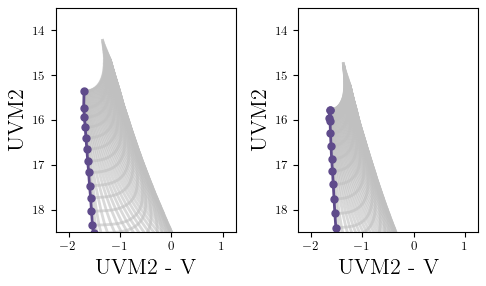

In [10]:
# Av Ranges:
# https://ui.adsabs.harvard.edu/abs/2002AJ....123..855Z # SMC, Fig 19
# https://ui.adsabs.harvard.edu/abs/2004AJ....128.1606Z # LMC, Fig 9
av_range = np.arange(0.01,1.,0.02) # Increasing the resolution will obviously slow down the fitting process quite a bit.

# Apply some level of extinction and then make one big grid 
def apply_extinction(df, extinction_coeff, av):
    # Copy the dataframe
    df_extincted = df.copy()
    # Apply the extinction
    for band in extinction_coeff.keys():
        df_extincted[band] = df[band] + extinction_coeff[band] * av
    # Add the Av column
    df_extincted['Av'] = av
    return df_extincted

smc_dfs = []
lmc_dfs = []
for av in av_range:
    smc_dfs.append(apply_extinction(s_comp.composite_df, smc_extinction_coeff, av))
    lmc_dfs.append(apply_extinction(l_comp.composite_df, lmc_extinction_coeff, av))

# Concatenate the dataframes
synth_smc = pd.concat(smc_dfs).reset_index(drop=True)
synth_lmc = pd.concat(lmc_dfs).reset_index(drop=True)

# Save the dataframes
synth_smc.to_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/smc_composite_photometry_extincted.csv', index=False)
synth_lmc.to_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/lmc_composite_photometry_extincted.csv', index=False)

# How big are these
print('Save Complete')
print('SMC Size: ',synth_smc.shape[0])
print('LMC Size: ',synth_lmc.shape[0])

# Take a look at one of the grids 
choose_av = 0.01
f, axes = plt.subplots(1,2,figsize=(5,3))
for ax, composite_df in zip(axes, [synth_lmc, synth_smc]):

    composite_df = composite_df[composite_df.Av == choose_av]

    for M in composite_df.M_MS.unique():
        comp_row = composite_df[(composite_df.M_MS == M) & (composite_df.frac_MS == 0.2)]
        ax.plot(comp_row.UVM2 - comp_row.V,comp_row.UVM2,color='silver',linewidth=2,alpha=0.6)

    for M in composite_df.Minit_strip.unique():
        comp_row = composite_df[(composite_df.Minit_strip == M) ] 
        ax.plot(comp_row.UVM2 - comp_row.V,comp_row.UVM2,color='silver',linewidth=2,alpha=0.6)
        
    evol = composite_df[composite_df.frac_MS == 0]
    ax.plot(evol.UVM2 - evol.V,evol.UVM2,color='#5F4B8B',linewidth=2,alpha=1,marker='o')
    ax.set_xlim(-2.25,1.25)
    ax.set_ylim(18.5,13.5)
    fs = 16
    ax.set_xlabel('UVM2 - V',fontsize=fs)
    ax.set_ylabel('UVM2',fontsize=fs)
plt.tight_layout()

## Fit the observed candidates

In [11]:
# Fitting Functions
# Chi Sq 
def chi_sq(obs_mag,obs_err,synth_mag):
    # Chi Square: Sum (Obs - Model) ^2 / error^2
    chi_df = (obs_mag - synth_mag)**2 / obs_err **2
    chi_sum = chi_df.sum(axis=1)
    return chi_sum
# MLE - Log Likelihood
def log_likelihood(obs_mag,obs_err,synth_mag):
    # ln(sigma^2)
    errs = (np.array(obs_err)**2).astype(float)
    err_sum = np.log(errs).sum()
    # Chi Square: Sum (Obs - Model) ^2 / error^2
    chi_sum = chi_sq(obs_mag,obs_err,synth_mag)
    log_likelihood = -1.0 * (chi_sum + err_sum)
    return log_likelihood
def fit(row,synth_photom):
    # Column names
    sums_mag_cols = ['uvw2','uvm2','uvw1','U','B','V','I']
    sums_err_cols = ['uvw2_err','uvm2_err','uvw1_err','e_U','e_B','e_V','e_I']
    
    # Get columns if both the mag and the err are finite 
    mag_cols = []
    err_cols = []
    for mag,err in zip(sums_mag_cols,sums_err_cols):
        if np.isfinite(row[mag]) & np.isfinite(row[err]):
            mag_cols.append(mag)
            err_cols.append(err)

    # SED and ERR
    obs_mag = np.array(row.loc[mag_cols].values)
    obs_err = np.array(row.loc[err_cols].values)

    # Get synthetic photometry based on what isn't a nan in the observed
    synth_mag_cols = [sums_col.split('_')[0].upper() for sums_col in mag_cols]
    synth_mag = synth_photom[synth_mag_cols].values

    # Number of photometry datapoints minus number of model parameters 
    # (3, 1 from stripped star model, 1 from MS model, 1 from extinction)
    dof = len(obs_mag) - 3
 
    # Chi Squared Statistic
    chi_sum = chi_sq(obs_mag,obs_err,synth_mag)

    # Log Likelihood
    log_likelihood_sum = log_likelihood(obs_mag,obs_err,synth_mag)

    # Where is chi minimized and what is the chi value
    min_reduced_chi_index = np.argmin(chi_sum)
    min_reduced_chi_value = chi_sum[min_reduced_chi_index]

    # Maximize Log Likelihood
    max_log_likelihood_index = np.argmax(log_likelihood_sum)
    max_log_likelihood_value = log_likelihood_sum[max_log_likelihood_index]

    
    return chi_sum, min_reduced_chi_index, min_reduced_chi_value, max_log_likelihood_index, max_log_likelihood_value, dof


###########
# Fitting #
###########
run = False
if run: 
    observed_dfs = []
    for gal,sf in zip(['smc','lmc'],[synth_smc,synth_lmc]):
        # Get observed candidates for this galaxy
        obs = df[df['galaxy'] == gal].reset_index(drop=True)
        names = sf.columns
        for ind,row in obs.iterrows():
            chi_sum, chi_index, chi_value, log_likelihood_index, log_likelihood_value, dof = fit(row,sf)
            # Add info about fit 
            obs.loc[ind,'fit_chi_sq_index'] = chi_index
            obs.loc[ind,'fit_chi_sq'] = chi_value
            obs.loc[ind,'fit_log_likelihood_index'] = log_likelihood_index
            obs.loc[ind,'fit_log_likelihood'] = log_likelihood_value
            obs.loc[ind,'fit_dof'] = dof
            # Add the best fit model to the dataframe
            for col in names:
                obs.loc[ind,f'fit_{col}'] = sf.loc[chi_index,col]
            # Add max and min values for M_companion and M_stripped_star within some confidence interval
            floor_chi =  chi_value # min chi value we get 
            q_sigma = 0.6827 # 1sigma confidence interval
            confidence_1 = floor_chi + chi2.ppf(q_sigma, dof)
            if np.isfinite(confidence_1):
                m_strips = sf.loc[chi_sum < confidence_1,'M_strip']
                m_comps = sf.loc[chi_sum < confidence_1,'M_MS']
            else:
                m_strips = np.array([np.nan])
                m_comps = np.array([np.nan])
            obs.loc[ind,'fit_M_strip_min'] = m_strips.min()
            obs.loc[ind,'fit_M_strip_max'] = m_strips.max()
            obs.loc[ind,'fit_M_MS_min'] = m_comps.min()
            obs.loc[ind,'fit_M_MS_max'] = m_comps.max()
        observed_dfs.append(obs)

    # Recombine 
    candidates = pd.concat(observed_dfs).reset_index(drop=True)
    # Save 
    candidates.to_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/4_stripped_star_candidates_fit.csv',index=False)

else:
    candidates = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/4_stripped_star_candidates_fit.csv')

## Visualize Results

In [12]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# The fit results for stripped stars candidates
l_candidates = candidates[candidates.galaxy == 'lmc'] 
s_candidates = candidates[candidates.galaxy == 'smc'] 

# Create columns to later constrain by
for gal_df in [l_candidates,s_candidates]:
    # Add width column for stripped stars
    gal_df['fit_strip_width'] = np.abs(gal_df['fit_M_strip_max'] - gal_df['fit_M_strip_min'])
    # Add width column for MS stars
    gal_df['fit_MS_width'] = np.abs(gal_df['fit_M_MS_max'] - gal_df['fit_M_MS_min'])
    # Determine a fractional error on stripped and ms stars individually
    gal_df['frac_err_strip'] = gal_df['fit_strip_width']/gal_df['fit_M_strip']
    gal_df['frac_err_MS'] = gal_df['fit_MS_width']/gal_df['fit_M_MS']


def cut_stars(gal_df,frac_err_limit):
    # Brightness cutoff 
    size = gal_df.shape[0]
    gal_df = gal_df.loc[gal_df['uvm2'] > 16.].reset_index(drop=True)
    print('brightness cut',gal_df.shape[0] - size)

    # "well_fit"
    size = gal_df.shape[0]
    q_5sigma = 0.999999 # confidence interval
    q_1sigma = 0.68
    # Remove if below 5sigma
    chi2_limit = np.array([chi2.ppf(q_5sigma, dof) for dof in gal_df.fit_dof])
    gal_df = gal_df.loc[gal_df.fit_chi_sq < chi2_limit].reset_index(drop=True)
    print('chi2 cut',gal_df.shape[0] - size)
    well_fit = gal_df.copy()
    
    # Two additional categories 
    size = gal_df.shape[0]
    # Get stars with fractional errors greater < frac_err_limit
    index_1 = gal_df.loc[(gal_df['frac_err_MS'] < frac_err_limit) &  (gal_df['frac_err_strip'] < frac_err_limit)].index
    print('frac_err: +',len(index_1)) 
    # Extra condition if MS/or stripped star is isolated
    index_2 = gal_df.loc[ (gal_df['fit_M_MS_min'] == 0.) & (gal_df['fit_MS_width'] < 3.)].index
    print('MS=0: +',len(index_2))
    # Checking that I'm not double counting
    for ind in index_1:
        if ind in index_2:
            print('In Both: ',ind)
    # Combine the indices
    index = index_1.union(index_2)
    # Remove duplicate indices
    index = index.drop_duplicates()
    # Select the rows with the combined indices
    gal_df = gal_df.loc[index].reset_index(drop=True)
    return gal_df, well_fit

frac_err_limit = 1
print('Init Total: ',len(candidates))
print(' ')
print('Init Size LMC: ',len(l_candidates))
l_candidates,l_well_fit = cut_stars(l_candidates,frac_err_limit)
print('Size LMC: ',len(l_candidates))
print(' ')
print('Init Size SMC: ',len(s_candidates))
s_candidates,s_well_fit = cut_stars(s_candidates,frac_err_limit)
print('Size SMC: ',len(s_candidates))
print(' ')
print('Final Total: ',len(l_candidates) + len(s_candidates))
well_fit = pd.concat([l_well_fit,s_well_fit],ignore_index=True)
all_candidates = pd.concat([l_candidates,s_candidates],ignore_index=True)

# Get the Grid 
def DistanceFromZams(df,zams,blue_band,red_band):
    data_x = df[blue_band] - df[red_band]
    data_y = df[blue_band]
    zams_blue = zams[blue_band.lower()]
    zams_red = zams[red_band.lower()]
    curve_x = np.array(zams_blue) - np.array(zams_red)
    curve_y = np.array(zams_blue)
    f = interpolate.interp1d(curve_x, curve_y)
    xnew = np.linspace(np.min(curve_x),np.max(curve_x),10000)
    ynew = f(xnew)

    # Where is data_y closest to ynew?
    distances = []
    for ind, row in df.iterrows():
        x = row[blue_band] - row[red_band]
        y = row[blue_band]
        i_ymin = np.argmin(np.abs(ynew - y))
        i_x = xnew[i_ymin]
        d = x - i_x
        distances.append(d)

    return np.array(distances)

def get_grid(composite_df,zams,blue_band,red_band):
    composite_df = composite_df.copy()
    composite_df['distance_from_zams'] = DistanceFromZams(composite_df,zams,blue_band,red_band)
    composite_df.loc[composite_df.distance_from_zams > 0.0,'blue'] = 'no'
    composite_df.loc[composite_df.distance_from_zams < 0.0,'blue'] = 'yes'
    X = np.sort(composite_df.M_strip.unique())
    Y = np.sort(composite_df.M_MS.unique())
    Y_not_calculated = np.arange(0.2,1.0,0.2)
    Y = np.sort(np.append(Y,Y_not_calculated))
    X,Y = np.meshgrid(X,Y)
    shape = X.shape
    X_flat,Y_flat = X.flatten(),Y.flatten()
    Z = []
    blues = []
    for x,y in zip(X_flat, Y_flat):
        blue_condition = composite_df[(composite_df.M_strip == x) & (composite_df.M_MS == y)].blue.values
        if len(blue_condition) == 1:
            if blue_condition == 'yes' or y == 0.0:
                Z.append(1)
            elif blue_condition == 'no':
                Z.append(0)
            else:
                Z.append(np.nan)
        else:
            Z.append(2)
    Z = np.array(Z).reshape(shape)
    return X,Y,Z

l_grid = get_grid(l_comp.composite_df,l_zams,'UVM2','V')
s_grid = get_grid(s_comp.composite_df,s_zams,'UVM2','V')

group2 = all_candidates.loc[ (all_candidates['fit_M_MS_min'] == 0.) & (all_candidates['fit_MS_width'] < 3.) ]
# How many are less than 2M in width 
print('Well Fit: ', well_fit.shape[0])
print(f'Zero MS Percent: {53/well_fit.shape[0]*100:.2f}%')
print(f'Frac err < 2: {group2[group2['frac_err_MS'] < 2].shape[0] / len(group2)*100:.2f}%') 
print(f'Fit MS width < 2: {group2[group2['fit_MS_width'] < 2].shape[0] / len(group2)*100:.2f}%') 
# No contribution from stripped stars (The minimum strip mass is 0)
M_Strip_Min_0 = well_fit[well_fit['fit_M_strip_min'] == 0.0]
print(f'No contribution from stripped stars (The minimum strip mass is 0) From well fit sample: {M_Strip_Min_0.shape[0]} or {M_Strip_Min_0.shape[0] / len(well_fit)*100:.2f}%')
print(f'No contribution from stripped star by best fit but width is within 3.5 solar masses: {M_Strip_Min_0[M_Strip_Min_0['fit_strip_width'] < 3.5].shape[0] / len(M_Strip_Min_0)*100:.2f}%')
print(f'No contribution from stripped star by best fit but width is within 3 solar masses: {M_Strip_Min_0[M_Strip_Min_0['fit_strip_width'] < 3].shape[0] / len(M_Strip_Min_0)*100:.2f}% or {M_Strip_Min_0[M_Strip_Min_0['fit_strip_width'] < 3].shape[0]}')
print(f'No contribution from stripped star by best fit but width is within 2 solar masses: {M_Strip_Min_0[M_Strip_Min_0['fit_strip_width'] < 2].shape[0] / len(M_Strip_Min_0)*100:.2f}%')
print(f'No contribution from stripped star by best fit but width is within 1.75 solar masses: {M_Strip_Min_0[M_Strip_Min_0['fit_strip_width'] < 1.75].shape[0] / len(M_Strip_Min_0)*100:.2f}%')
print(f'No contribution from stripped star by best fit but width is a minimum solar masses: {M_Strip_Min_0['fit_strip_width'].min()}')
print(f'Group 2 MS mass range: {group2['fit_M_MS_min'].min()} - {group2['fit_M_MS_max'].max()}')
print(f'Group 2 Stripped mass range: {group2['fit_M_strip_min'].min()} - {group2['fit_M_strip_max'].max()}')
print('How many Mstrip over 6: ',all_candidates[all_candidates.fit_M_strip >6].shape[0])

Init Total:  820
 
Init Size LMC:  522
brightness cut -137
chi2 cut -122
frac_err: + 158
MS=0: + 39
Size LMC:  197
 
Init Size SMC:  298
brightness cut -55
chi2 cut -61
frac_err: + 92
MS=0: + 14
Size SMC:  106
 
Final Total:  303
Well Fit:  445
Zero MS Percent: 11.91%
Frac err < 2: 60.38%
Fit MS width < 2: 41.51%
No contribution from stripped stars (The minimum strip mass is 0) From well fit sample: 72 or 16.18%
No contribution from stripped star by best fit but width is within 3.5 solar masses: 91.67%
No contribution from stripped star by best fit but width is within 3 solar masses: 87.50% or 63
No contribution from stripped star by best fit but width is within 2 solar masses: 65.28%
No contribution from stripped star by best fit but width is within 1.75 solar masses: 48.61%
No contribution from stripped star by best fit but width is a minimum solar masses: 0.62
Group 2 MS mass range: 0.0 - 2.8
Group 2 Stripped mass range: 0.8 - 4.13
How many Mstrip over 6:  2


Candidates plotted: 197
Mstrip -> min:0.62 max:7.14 median:1.05 mean:1.50
MMS -> min:0.0 max:5.8 median:2.0 mean:2.15
Candidates plotted: 106
Mstrip -> min:0.67 max:3.36 median:1.15 mean:1.38
MMS -> min:0.0 max:4.2 median:2.6 mean:2.46


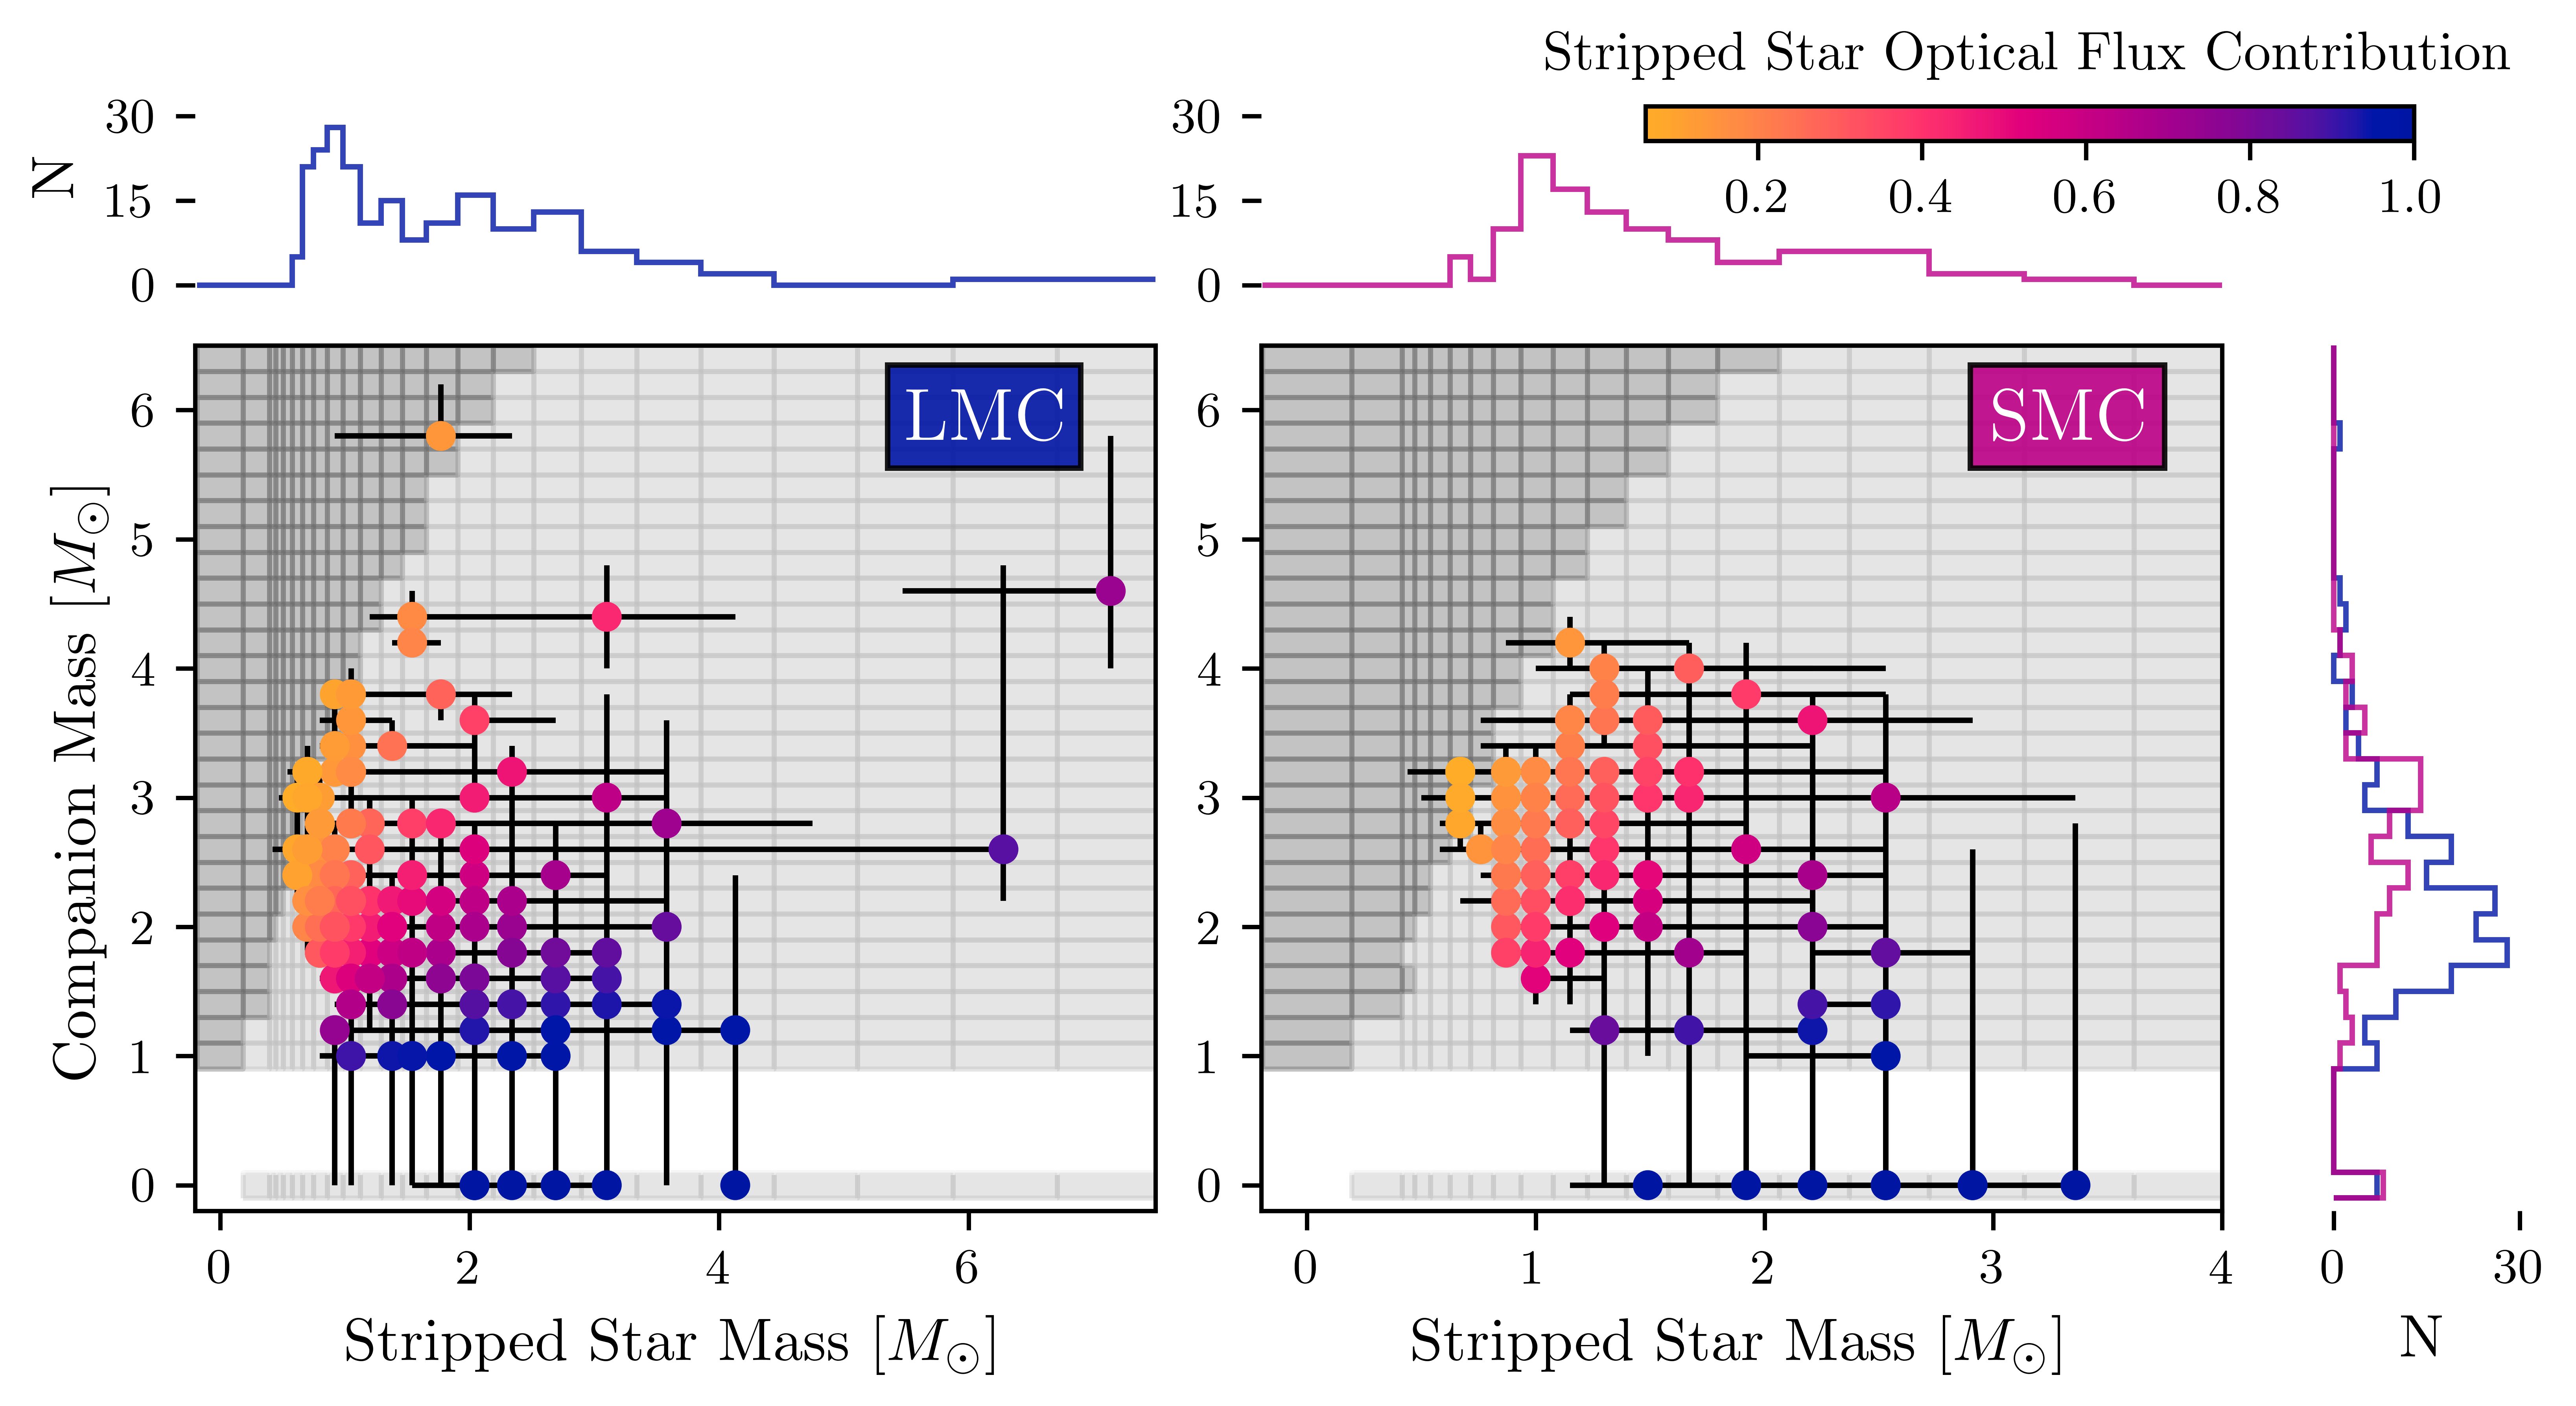

In [ ]:
fig_w = 7.12663097223 +0.5
fig_h = 3.8
cmap = cc.cm.bmy_r
scatter_colors = truncate_colormap(cmap, 0.2,0.9)
marker_size = 20
lmc_color = '#0015A5'
smc_color = '#BC0087'

f = plt.figure(constrained_layout=False, figsize=(fig_w, fig_h),dpi=1000)

# Use gridspec to set the size of the subplots for the first two 
size_low = 0.05
size_high = 0.2
size_mid = 1 - size_low - size_high
width = 1
# Init gridspec 
gs = f.add_gridspec(2, 3,  height_ratios=(size_high, size_mid),width_ratios=(width,width,size_high))
gs.update(wspace=0.15, hspace=0.1)

# Top Histogram 
lmc_hist = f.add_subplot(gs[0,0])
smc_hist = f.add_subplot(gs[0,1])

# Side Histogram 
both_hist = f.add_subplot(gs[1,2])

# Main plot 
l_ax_t = f.add_subplot(gs[1,0])
r_ax_t = f.add_subplot(gs[1,1])


top = [l_ax_t,r_ax_t]
hist = [lmc_hist,smc_hist,both_hist]


# Set ticks
[ax.set_xticks([]) for ax in hist[0:2]]
both_hist.set_yticks([]) 
[ax.tick_params(axis='both', which='major') for ax in hist]


# Remove the spines from the histograms
[ax.spines[:].set_visible(False) for ax in hist]

# Set labels
top[0].set_ylabel(r'Companion Mass [$M_{\odot}$]')


cands = []
colorbars = []
for galaxy in ['lmc','smc']:
    if galaxy == 'lmc':
        ax = l_ax_t
        ax_hist = lmc_hist
        color_hist = lmc_color
        candidates = l_candidates
        X,Y,Z = l_grid
        xdim = [-0.2,7.5]
        ydim = [-0.2,6.5]
  
    else:
        ax = r_ax_t
        ax_hist = smc_hist
        color_hist = smc_color
        candidates = s_candidates
        X,Y,Z = s_grid
        xdim = [-0.2,4.]
        ydim = [-0.2,6.5]

    # Scattter plot 
    print(f'Candidates plotted: {len(candidates)}')
    print(f'Mstrip -> min:{candidates.fit_M_strip.min()} max:{candidates.fit_M_strip.max()} median:{candidates.fit_M_strip.median()} mean:{candidates.fit_M_strip.mean():.2f}')
    print(f'MMS -> min:{candidates.fit_M_MS.min()} max:{candidates.fit_M_MS.max()} median:{candidates.fit_M_MS.median()} mean:{candidates.fit_M_MS.mean():.2f}')
    cax = ax.scatter(candidates.fit_M_strip,candidates.fit_M_MS,c=candidates.fit_V_flux_frac,cmap=scatter_colors,s=marker_size,alpha=1,zorder=10)
    # Horrizontal Errorbars: X axis, First value is Y position
    ax.hlines(candidates.fit_M_MS, candidates.fit_M_strip_min, candidates.fit_M_strip_max,color='k',zorder=9)
    # Vertical Errorbars: Y axis, First value is X position
    ax.vlines(candidates.fit_M_strip, candidates.fit_M_MS_min, candidates.fit_M_MS_max,color='k',zorder=9)
    colorbars.append(cax)
    ax.set_xlim(xdim)
    ax.set_ylim(ydim)
    ax.set_xlabel(r'Stripped Star Mass [$M_{\odot}$]')

    # Grid
    grid_alpha = 0.4
    cMap = colors.ListedColormap(['dimgrey','silver','black'])
    cMap = colors.ListedColormap(['silver','whitesmoke','dimgrey'])
    cMap = colors.ListedColormap(['dimgrey','silver','white'])

    pcol = ax.pcolormesh(X,Y,Z,cmap=cMap,linewidth=0.8,alpha=grid_alpha,zorder=-1) # rasterized=True,
    pcol.set_edgecolor('face')

    # Histograms 
    # Get bins from pcolormesh 
    xbins = np.array(pcol.get_coordinates()[0,:,0])
    ybins = np.array(pcol.get_coordinates()[:,0,1])

    # Make histogram for the top 
    hist, bins, _ = ax_hist.hist(candidates.fit_M_strip,bins=xbins,color=color_hist,alpha=0.8,histtype='step',lw=1,range=(xdim[0],xdim[1]))
    ax_hist.set_xlim(xdim)
    ax_hist.set_ylim(-1,40)
    hist_yticks = [0,15,30]
    hist_yticks = [0,15,30]
    ax_hist.set_yticks(hist_yticks)
    ax_hist.set_yticklabels([str(i) for i in hist_yticks])
    
    # Make histogram for the side
    hist, bins, _ = both_hist.hist(candidates.fit_M_MS,bins=ybins,color=color_hist,alpha=0.8,histtype='step',orientation='horizontal',lw=1,range=(ydim[0],ydim[1]))
    both_hist.set_ylim(ydim)
    both_hist.set_xlim(-1,30)
    xticks = [0,30]
    both_hist.set_xticks(xticks)
    both_hist.set_xticklabels([str(i) for i in xticks])
    both_hist.set_xlabel('N')


# Galaxy labels 
gal_text_color = 'white'
w= 0.75 # under 16 


# Rectangles for the galaxy label
bw = .2
box_x_lmc = 5.5
box_x_smc = 3
l_ax_t.add_patch(plt.Rectangle((box_x_lmc-bw+0.05,ydim[1]-w-bw), 1.55, 0.8,ec='k',fc=lmc_color,alpha=0.9))
r_ax_t.add_patch(plt.Rectangle((box_x_smc-bw+0.1,ydim[1]-w-bw),0.85, 0.8,ec='k',fc=smc_color,alpha=0.9))
                        
# Text for the galaxy label
fs=13.5
l_ax_t.text(box_x_lmc,ydim[1]-w+0.01,'LMC',color=gal_text_color,weight='demi',fontsize=fs)
r_ax_t.text(box_x_smc,ydim[1]-w+0.01,'SMC',color=gal_text_color,weight='demi',fontsize=fs)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
ticks = list(np.arange(0,1.2,0.2))
tick_labels = [str(np.round(tick,1)) for tick in ticks]

axins = inset_axes(smc_hist, # here using axis of the lowest plot
               width="80%",  # width = X% of parent_bbox width
               height="15%",  
               bbox_to_anchor=(.2, -0.2, 1., 1.),
               bbox_transform=smc_hist.transAxes,
               borderpad=0,
               )
lmc_hist.set_ylabel('N')
cbar = f.colorbar(colorbars[0], cax=axins,ticks=ticks,orientation='horizontal')
cbar.ax.set_xticklabels(tick_labels) 
cbar.set_label('Stripped Star Optical Flux Contribution',labelpad=-35,fontsize=10)

# Having a hard time vectorizing because the color in the colorbar doesnt appear. 

plt.savefig('SED_Fitting.pdf',dpi=1000)